# Summary

Solve for a velocity (fault slip) b.c. and visualize – for a period of time – the sequence of isochrones (time slices of the topographic profile) and the rays that are used to infer them. The shape of each isochrone is identical, i.e., the profiles are time-invariant. 

With a view to handling variable, complex slip conditions, the isochrones here are not generated from a single ray, but instead rays are integrated repeately from the left slip boundary. Here this is a rather inefficient, because the slip rate is constant. In other notebooks (see `Knickpoints`) the boundary condition is made more interesting.

### Parameter files

In [1]:
# Specify the parameter files for the job
import os
if 'GME_NB_PR' not in os.environ.keys():
#     pr_filenames = ['VelocityBoundary_sinbeta_ramp_eta1p5_ratio0p5_xiv10']
#     pr_filenames = ['VelocityBoundary_sinbeta_ramp_eta0p5_ratio0p5_xiv80']
#     pr_filenames = ['VelocityBoundary_eta1p5_Ci4']
    pr_filenames = ['VelocityBoundary_eta0p5_Ci4']
else:
    pr_filenames = eval(os.environ['GME_NB_PR'])

### Logging

In [2]:
from importlib import reload
import logging, sys
reload(logging)
logging.basicConfig(level=logging.INFO, format=f'%(message)s') #stream=sys.stdout, 

### Modules

In [3]:
# Import Numpy
import numpy as np

# Import SymPy and set up latex inline & pretty dict printing
import sympy as sy
from sympy import simplify, Matrix, Eq, Rational, factor, poly, solve, numer, deg
# Set up latex inline printing
sy.init_printing(pretty_print=True,wrap_line=True)

# Import units & dimensions
from sympy.physics.units import degrees
from sympy.physics.units.systems import SI

# Pretty dict printing etc
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from datetime import datetime

# Import Geomorphysics library functions, classes
from gmplib.utils import numify, export_results, e2d, omitdict, convert
from gmplib.save import create_directories, export_plots
from gmplib.parameters import import_parameters, Parameters

# Import GME classes and do a wildcard (!) import of all GME symbol definitions
from gme.core.symbols import eta, mu, Lc, Ci, varepsilon, varepsilonhat, beta_0,\
                              xiv_0, xih_0
# , h_0p9, th_0p9, h_0p95, th_0p95from gme.core.equations import Equations, EquationSubset
from gme.core.equations import Equations, EquationSubset
from gme.ode.velocity_boundary import VelocityBoundarySolution
from gme.plot.time_dependent import TimeDependent

# Import units & dimensions
from sympy.physics.units import degrees

# Decide where we're working and thus where to find the job parameter files
#   -  use the GME_WORKING_PATH environment variable if it's defined
#   -  otherwise, deduce that we're working in the GME notebook dir
if 'GME_WORKING_PATH' in os.environ.keys():
    working_path = os.environ['GME_WORKING_PATH']
    print(f'Fetching working path from environment variable GME_WORKING_PATH = {working_path}')
else:
    from gmplib.utils import get_pkg_path
    import gme
    working_path = get_pkg_path(gme, dirname='')
    print(f'Deducing working path from GME package location = {working_path}')
    del gme
    
# Set the path to the parameter files for this nb and report
pr_path = os.path.join(working_path,'Parameters','RayTracing')
pr_path, pr_filenames

Deducing working path from GME package location = /Users/colinstark/Projects/GME


('/Users/colinstark/Projects/GME/Parameters/RayTracing',
 ['VelocityBoundary_eta0p5_Ci4'])

### Parameter parsing

In [4]:
# Read and combine the default and job parameter files, and report

parameters_dict,_ = import_parameters([pr_path], 
                                      [os.path.join('..','defaults'), *pr_filenames])
pr = Parameters(parameters_dict, evaluations={}, sequence=())
[pp(psubobj.__dict__) for psubobj \
     in (pr.job, pr.model, pr.solve, pr.resolve, pr.plot, pr.save)];

{   'debug': False,
    'group_name': 'VelocityBoundarySolutions',
    'short_name': 'vbs',
    'subtitle': '',
    'title': 'Velocity boundary solution: vertical, ramp, Ci=4deg',
    'verbose': True,
    'very_verbose': False}
{   'Ci': pi/45,
    'Lc': 10000,
    'beta_type': 'sin',
    'do_geodesic': False,
    'eta': 1/2,
    'h_0': 1/2,
    'ibc_type': 'concave-up',
    'kappa_h': 3/2,
    'mu': 1/4,
    't_xiv0_list': None,
    'varepsilonhat': 1/100,
    'varphi_0': 2.641e-05,
    'varphi_type': 'ramp',
    'vb_type': 'vertical',
    'x_h': 1,
    'x_sigma': 0.01,
    'xiv_0': None}
{   'choice': 'Hamilton',
    'do_dense': True,
    'do_geodesic': True,
    'do_ic': False,
    'do_ip': False,
    'do_vb': False,
    'ic_res': 31,
    'ip_res': 101,
    'method': {'Hamilton': 'DOP853', 'geodesic': 'LSODA'},
    'ray_n_t': 101,
    't_distribn': 2,
    't_end': 10,
    't_slip_end': 10,
    'vb_res': 501}
{   'do_eliminate_caustics': True,
    'n_isochrones': 30,
    'spline_orde

In [5]:
# # Create a dict of the key physics parameters to be used in substitutions

# sub = {x_1: pr.model.x_1, 
#        varepsilon: pr.model.varepsilon, 
#        varphi_0: pr.model.varphi_0,
#        xiv_0: pr.model.xiv_0,
#        kappa_h: pr.model.kappa_h,
#        h_0: pr.model.h_0,
#        x_sigma: pr.model.x_sigma,
#        x_h: pr.model.x_h}
# Eq(eta,pr.model.eta), Eq(mu,pr.model.mu), Eq(mu/eta,pr.model.mu/pr.model.eta), sub

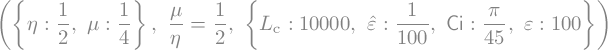

In [6]:
# Create a dict of the key physics parameters to be used in substitutions
subexp = {
    eta: pr.model.eta,
    mu: pr.model.mu
}
sub = {
    Ci: pr.model.Ci, 
    Lc: pr.model.Lc, 
    varepsilonhat: pr.model.varepsilonhat, 
    varepsilon: pr.model.varepsilonhat*pr.model.Lc 
}
subexp, Eq(mu/eta,pr.model.mu/pr.model.eta), sub

# Equations

Derive the GME equation set (using Sympy) for a specific erosion model.

In [7]:
gmeq = Equations( eta_=pr.model.eta, 
                  mu_=pr.model.mu, 
                  beta_type=pr.model.beta_type, 
                  varphi_type=pr.model.varphi_type,
                  ibc_type=pr.model.ibc_type,
                  parameters=sub, do_raw=True )

# Integration

Integrate Hamilton's equations in $(\mathbf{r}, \mathbf{\widetilde{p}})[t]$ for a given vertical component of the erosion rate (initial condition) equivalent to a constant vertical velocity (boundary condition). In other words, given a value for vertical slip rate $\xi^{\downarrow}$ at the boundary at $x=0$, where the initial ray position is $\left.(r^x, r^z)\right|_{t=t_0} = (0,\xi^{\downarrow}t_0)$, specify the initial value of the vertical component of the normal-slowness covector $p_z[t=t_0] = \left.-1/\xi^{\downarrow}\right|_{x=0}$.  The horizontal component of the initial covector $p_x[t=t_0]$ is computed by calculating the surface gradient $\left.\tan\beta\right|_{x=0}$ from the erosion model and then using $-p_x/p_z = \tan\beta$. Do this ray tracing repeatedly for a sequence of values of $t_0$.

Various ODE quadrature methods provided by SciPy's `solve_ivp` function can be used here:
"DOP853" (explicit Runge-Kutta method of order 8(5,3)  with dense output of order 7); basic Runge-Kutta (RK45 or RK23); "Radau" (implicit Runge-Kutta method of the Radau IIA family of order 5); "BDF" (implicit multi-step variable-order (1 to 5) method based on a backward differentiation formula for the derivative approximation); "LSODA" (Adams/BDF method with automatic stiffness detection and switching). "Radau" is by far the most accurate (in terms of computing surface gradient); "DOP853" is less accurate, but its computation of vertical erosion rate is quite robust. "BDF" computes gradient a bit better, but its vertical erosion rate is less accurate. All quadrature methods have very similar timings.


Test timings for `VelocityBoundary_tanbeta_rampflat_eta1p0_xiv30_xh0p5`:
  - DOP853:  155s
  - Radau:   157s
  - RK45:   153s
  - RK23:   151s
  - BDF:   157s
  - LSODA:   155s

In [8]:
pr.model.beta_0 = float(beta_0.subs(e2d(gmeq.beta0_Ci_eqn
                                        .subs(omitdict(sub,[beta_0])).subs(subexp))))
sub.update({beta_0:pr.model.beta_0})
convert(Eq(beta_0, pr.model.beta_0), n=2, units=degrees, do_raw=False)

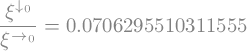

In [9]:
xivh0_ = float((xiv_0/xih_0).subs(e2d(gmeq.xiv0_xih0_Ci_eqn)).subs(sub).subs(subexp).n())
sub.update({(xiv_0/xih_0):xivh0_})
Eq(xiv_0/xih_0, sub[xiv_0/xih_0])

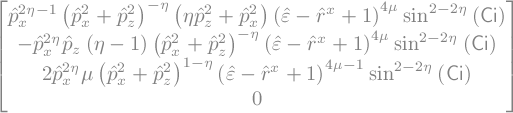

In [10]:
gmeq.hamiltons_ndim_eqns

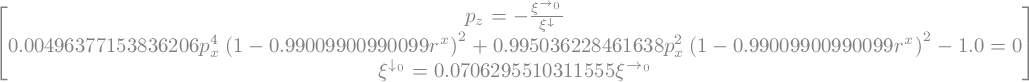

In [11]:
gmeq_ndim_subset = EquationSubset(gmeq, sub, do_ndim=True, do_revert=True) 
Matrix([
    gmeq_ndim_subset.pz_xiv_eqn,
    gmeq_ndim_subset.poly_px_xiv0_eqn,
    gmeq_ndim_subset.xiv0_xih0_Ci_eqn
])

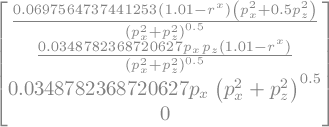

In [12]:
Matrix([gmeq_ndim_subset.hamiltons_eqns])

Create an instance of the ODE solution object.

In [13]:
# pr.solve.vb_res = 501
# pr.solve.ray_n_t = 101
# pr.plot.ray_subsetting = 25

In [14]:
# pr.solve.t_end = 0.01
# pr.solve.t_slip_end = 0.009
# pr.resolve.t_isochrone_max = 0.013

In [15]:
# pr.solve.vb_res = 11
# # pr.solve.ray_n_t = 11
# pr.plot.ray_subsetting = 1

In [16]:
# gmeq.varphi_rx_eqn.subs(sub)

In [17]:
# pr.solve.do_dense = False
# pr.solve.method[pr.solve.choice] = 'RK23'

In [18]:
# pr.solve.t_end = 5
# pr.solve.t_slip_end = 10

In [19]:
# pr.solve.ray_n_t = 11
# pr.solve.vb_res = 6

In [20]:
xmax_ = 0.999 #float(1-varepsilonhat.subs(sub))

In [21]:
# reload(logging); logging.basicConfig(level=logging.INFO, format=f'%(message)s')

In [22]:
gmes = VelocityBoundarySolution( gmeq_ndim_subset, parameters=sub, 
                                 t_end=pr.solve.t_end, 
                                 t_slip_end=pr.solve.t_slip_end, 
                                 x_stop=xmax_,
                                 n_t=pr.solve.ray_n_t, 
                                 t_distribn=pr.solve.t_distribn,
                                 n_rays=pr.solve.vb_res,
                                 choice=pr.solve.choice, 
                                 method=pr.solve.method[pr.solve.choice],
                                 do_dense=pr.solve.do_dense )

ode.base.BaseSolution.init: Solve Hamilton's ODEs using DOP853 method of integration


Specify the set of ODEs and integrate them.

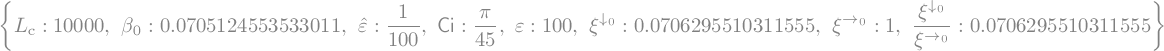

In [23]:
sub.update({xiv_0:xivh0_, xih_0:1})
sub

Process the above output, which takes the form of time series of positions $\{\vec{r}\}$ and front normal slownesses $\{\mathbf{p}\}$, into various arrays.

In [24]:
start_time = datetime.now() 
gmes.solve()
datetime.now() - start_time 

0% 

ode.base.BaseSolution.make_model: Constructing model Hamilton's equations


1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 


datetime.timedelta(seconds=3, microseconds=506589)

In [25]:
soln = gmes.ivp_solns_list[0]
print(f'Number of ray-traced solutions: {len(gmes.ivp_solns_list)}\n\n'
      f'Message: {soln.message}\nSuccess? {soln.success}',
      f'\nStatus:{soln.status}\nt_final: {soln.t[-1]}\nrx_final: {soln.y[0][-1]}')

Number of ray-traced solutions: 501

Message: A termination event occurred.
Success? True 
Status:1
t_final: 5.929
rx_final: 0.9978920775299661


Process the above output, which takes the form of time series of positions $\{\vec{r}\}$ and front normal slownesses $\{\mathbf{p}\}$, into various arrays.

In [26]:
gmes.postprocessing()

In [27]:
gmes.resolve_isochrones( t_isochrone_max=pr.resolve.t_isochrone_max, 
                         tolerance=pr.resolve.tolerance, 
                         n_isochrones=pr.resolve.n_isochrones,
                         n_resample_pts=301,
                         do_eliminate_caustics=pr.resolve.do_eliminate_caustics )

# Plots

Visualization of results

## Preliminaries

In [28]:
gr = TimeDependent()

In [29]:
prefix = pr.job.short_name

suffix  = f'_eta{float(sy.N(pr.model.eta))}'
suffix += f'_Ci{float(sy.N(sy.deg(pr.model.Ci)))}'

job_name = prefix+suffix.replace('.','p')
job_name

'vbs_eta0p5_Ci4p0'

## Graphs

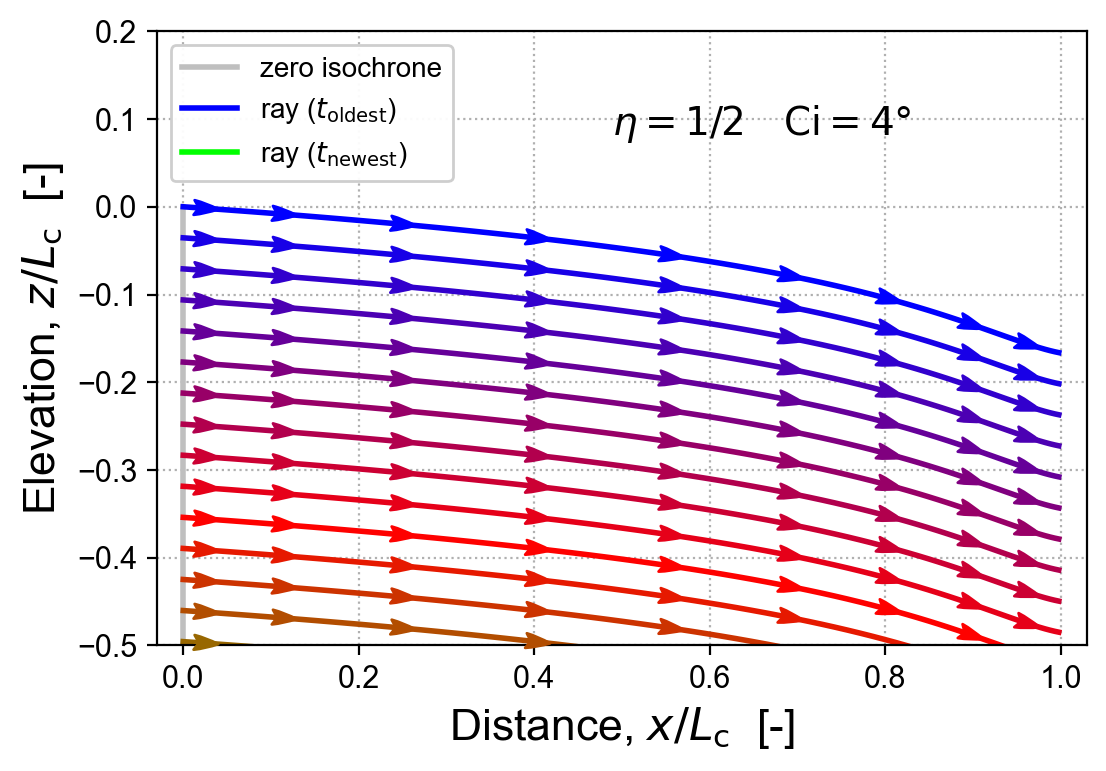

In [30]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_rays', fig_size=(6,6), 
                       do_zero_isochrone=True, do_rays=True, ray_lw=2,
                       ray_subsetting=pr.plot.ray_subsetting, 
                       arrow_sf=0.8, arrow_offset=10,
                       do_isochrones=False, do_annotate_rays=True, n_arrows=9, 
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits,
                       do_smooth_colors=True,
                       do_etaxi_label=True, 
                       eta_label_xy=pr.plot.pub_label_posns['etaxi_label'],
                       do_pub_label=pr.plot.do_pub_labeling, 
                       pub_label=pr.plot.pub_labels['profile_h_rays'], 
                       pub_label_xy=pr.plot.pub_label_posns['profile_h_rays']);

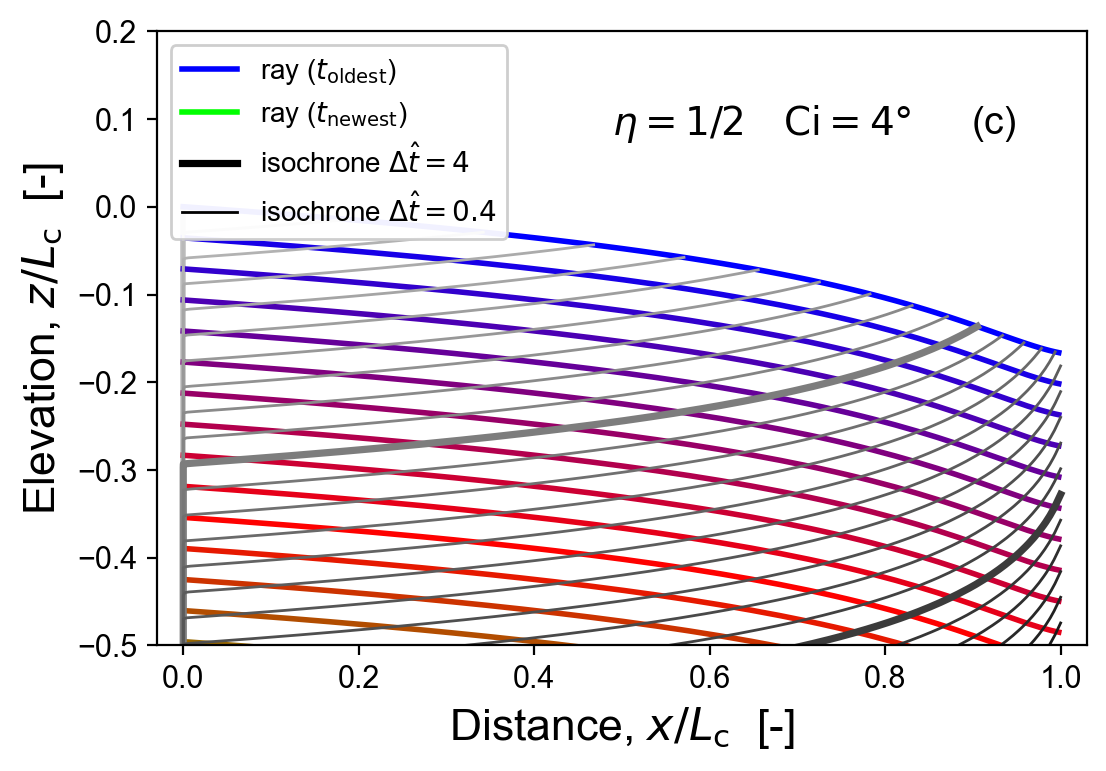

In [31]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones_rays', fig_size=(6,6), 
                       do_zero_isochrone=True, do_rays=True, ray_lw=2,
                       ray_subsetting=pr.plot.ray_subsetting, 
                       do_isochrones=True, isochrone_lw=2,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits,
                       do_legend=False, do_alt_legend=True, do_grid=False,
                       do_smooth_colors=True,
                       do_etaxi_label=True, 
                       eta_label_xy=pr.plot.pub_label_posns['etaxi_label'],
                       do_pub_label=pr.plot.do_pub_labeling,
                       pub_label=pr.plot.pub_labels['profile_h_isochrones_rays'], 
                       pub_label_xy=pr.plot.pub_label_posns['profile_h_isochrones_rays']);

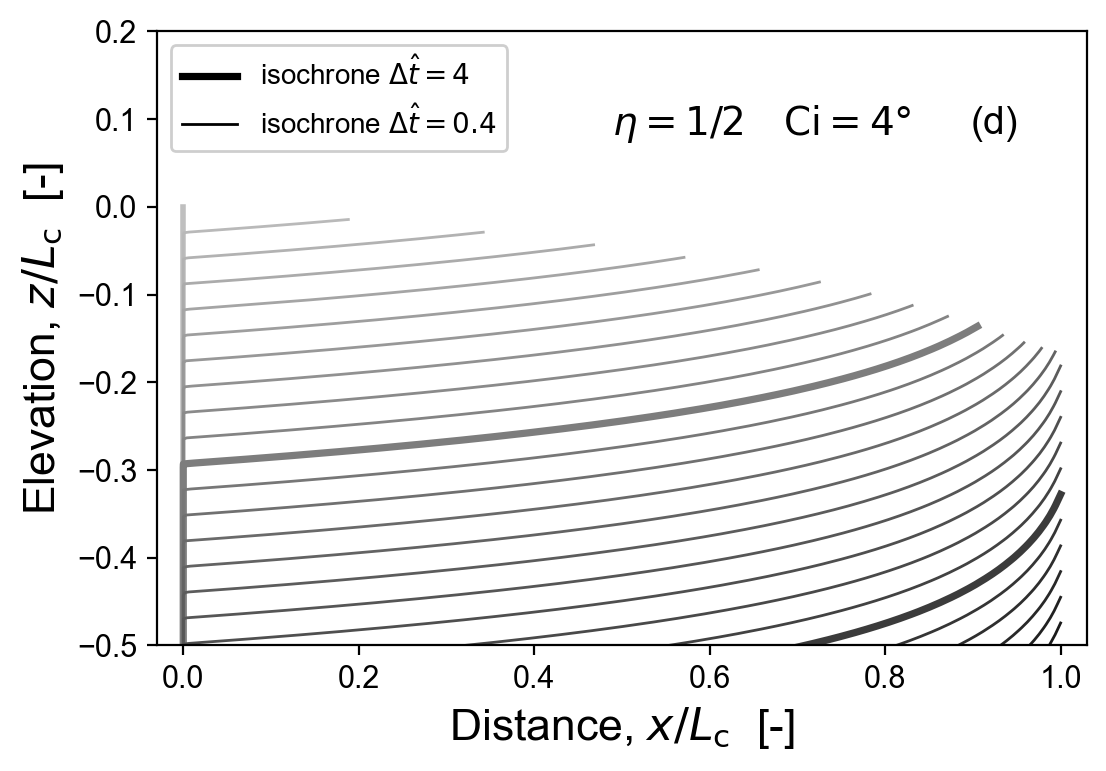

In [32]:
gr.profile_isochrones( gmes, gmeq, sub, job_name+'_h_isochrones', fig_size=(6,6), 
                       do_zero_isochrone=True, do_rays=False, 
                       do_isochrones=True, isochrone_lw=2,
                       ray_subsetting=pr.plot.ray_subsetting,
                       isochrone_subsetting=pr.plot.isochrone_subsetting,
                       x_limits=pr.plot.dimx_limits, y_limits=pr.plot.dimz_limits,
                       do_legend=False, do_alt_legend=True, do_grid=False,
                       do_etaxi_label=True, 
                       eta_label_xy=pr.plot.pub_label_posns['etaxi_label'],
                       do_pub_label=pr.plot.do_pub_labeling,
                       pub_label=pr.plot.pub_labels['profile_h_isochrones'], 
                       pub_label_xy=pr.plot.pub_label_posns['profile_h_isochrones']);

# Save

Export the graphs as PNG and/or PDF image files.

In [33]:
plots_dir = create_directories(pr.save.figs_path, pr.job.group_name)
export_plots( gr.fdict, plots_dir, pr.save.figs_format, suffix='' )